# Exploratory analysis of symbol/glyph detection.
For this analysis I am using YOLOv5 to detect points in the DARPA Mineral Assessment Challenge.

The notebook is structure as follows
*   Environment Setup
*   Data Prep
 *   Map Patching
 *   YOLO annotations
*   Training
*   Visualizations




# Environment Setup
To use YOLO v5 we will begin by cloning the repository and setting up it's dependencies. We will also install Patchify as we will need to for breaking the map into consistant size patches.

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)

Cloning into 'yolov5'...
remote: Enumerating objects: 14340, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 14340 (delta 89), reused 98 (delta 52), pack-reused 14194
Receiving objects: 100% (14340/14340), 13.36 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (9901/9901), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)
     |████████████████████████████████| 1.6 MB 5.3 MB/s 


In [2]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.12.1+cu113 CPU


In [4]:
import os
import json
import cv2
import numpy as np
from patchify import patchify
from matplotlib import pyplot as plt
from math import floor, ceil

# Data Prep
To begin using prepare for the data for  YOLO on the DARPA map data we will first need to find the number of the classes our model will need to classify and convert the training data point masks to to YOLO annotations.

The training data is expected to be loose files in the `trainDataFolder` just like they were distributed by the the DARPA Challenge. 

There are a couple of options that we can take when patching the map. We can change the size of the patches and the overlap of each patch.

## Explore the Dataset

In [58]:
sourceDataFolder = 'training'
patchDataFolder = 'data'
# These paths are expected by yolo probably shouldn't change them
patchTrainFolder = 'images/train'
patchLabelFolder = 'labels/train'

if not os.path.exists(os.path.join(patchDataFolder, patchTrainFolder)):
    os.makedirs(os.path.join(patchDataFolder, patchTrainFolder))
if not os.path.exists(os.path.join(patchDataFolder, patchLabelFolder)):
    os.makedirs(os.path.join(patchDataFolder, patchLabelFolder))

In [8]:
pt_classes = {}
class_id = 0
# Iterate through each json file.
for file in os.listdir(sourceDataFolder):
    if not file.endswith(".json"):
        continue
    
    # Load Json
    with open(os.path.join(sourceDataFolder, file)) as fh:
        json_data = json.load(fh)
    
    for shape in json_data['shapes']:
        if shape['label'].split('_')[-1] == 'pt':
            if shape['label'] in pt_classes:
                pt_classes[shape['label']][1] += 1
            else:
                pt_classes[shape['label']] = [class_id, 1]
                class_id += 1

print('There are {} classes in the dataset'.format(len(pt_classes.keys())))
print('class_name : [id, number of maps it occurs in]')
print(pt_classes)

There are 5 classes in the dataset
class_name : [id, number of maps it occurs in]
{'1_pt': [0, 5], '5_pt': [1, 5], '2_pt': [2, 1], '3_pt': [3, 1], '4_pt': [4, 1]}


## Patching the Maps
The next thing is to patch the images and generate the annotations (labels) for each patch

In [9]:
# PatchSettings
patch_dims = (512,512)
patch_overlap = 64
patch_step = patch_dims[1]-patch_overlap

In [59]:
# Iterate through each json file.
for file in os.listdir(sourceDataFolder):
    if not file.endswith(".json"):
        continue
    
    # Load Json
    with open(os.path.join(sourceDataFolder, file)) as fh:
        json_data = json.load(fh)

    # Load Base Image
    if json_data['imagePath'][0:3] == '..\\':
        json_data['imagePath'] = json_data['imagePath'][3:]
    base_filePath = os.path.join(sourceDataFolder, json_data['imagePath'])
    base_img = cv2.imread(base_filePath)
    if base_img is None:
        continue
    base_patchs = patchify(base_img, (*patch_dims,3), step=patch_step)

    # Save patches to training data
    print('{} : {} x {} = {} Patches'.format(json_data['imagePath'], base_patchs.shape[0], base_patchs.shape[1], base_patchs.shape[0]*base_patchs.shape[1]))
    for row in range(0,base_patchs.shape[0]):
        for col in range(0,base_patchs.shape[1]):
            patch_fileName = '{}_{}_{}.png'.format(json_data['imagePath'].split('.')[0],row, col)
            patch_filePath = os.path.join(patchDataFolder, patchTrainFolder, patch_fileName)
            cv2.imwrite(patch_filePath, base_patchs[row][col].squeeze())

WI_Wyeville_503636_1958_48000_geo_mosaic.tif : 18 x 14 = 252 Patches
WI_Pittsville_503467_1957_48000_geo_mosaic.tif : 18 x 14 = 252 Patches
WI_WisconsinRapids_503634_1957_48000_geo_mosaic.tif : 18 x 14 = 252 Patches
WI_Marathon_503365_1953_48000_geo_mosaic.tif : 18 x 14 = 252 Patches
UT_Beaver_248048_1937_48000_geo_mosaic.tif : 17 x 10 = 170 Patches
WI_StevensPoint_700274_1956_48000_geo_mosaic.tif : 18 x 14 = 252 Patches
WI_NewLondon_800429_1956_48000_geo_mosaic.tif : 17 x 14 = 238 Patches
WI_CityPoint_502310_1957_48000_geo_mosaic.tif : 18 x 14 = 252 Patches


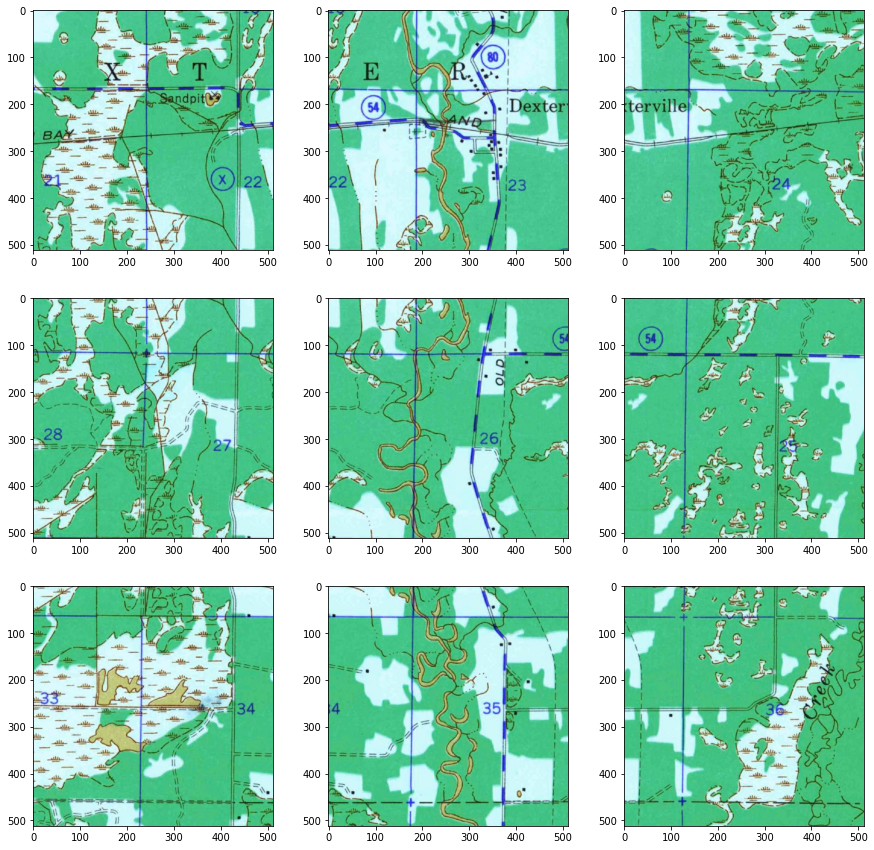

In [25]:
# Sample plot of the last image patchs
plot_patchs = base_patchs.squeeze()
center_tile = (len(plot_patchs)//2,len(plot_patchs[0])//2)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0][0].imshow(plot_patchs[center_tile[0]-1][center_tile[1]-1])
axs[0][1].imshow(plot_patchs[center_tile[0]-1][center_tile[1]])
axs[0][2].imshow(plot_patchs[center_tile[0]-1][center_tile[1]+1])

axs[1][0].imshow(plot_patchs[center_tile[0]][center_tile[1]-1])
axs[1][1].imshow(plot_patchs[center_tile[0]][center_tile[1]])
axs[1][2].imshow(plot_patchs[center_tile[0]][center_tile[1]+1])

axs[2][0].imshow(plot_patchs[center_tile[0]+1][center_tile[1]-1])
axs[2][1].imshow(plot_patchs[center_tile[0]+1][center_tile[1]])
axs[2][2].imshow(plot_patchs[center_tile[0]+1][center_tile[1]+1])

plt.show()

## Generating YOLO Annotations

In [11]:
def clamp(value, lower_bound=0.0, upper_bound=1.0):
    return max(min(value, upper_bound), lower_bound)

In [12]:
# Generates yolo formatted annotations from a point mask image with the size of the bounding box given by bbox_shape
def generate_yolo_annotations(points_mask, bbox_shape, class_id):
    # Get list of non-zero pixels 
    points = np.argwhere(points_mask)
    # Convert point to yolo format (class_id, x_center, y_center, width, height)
    annotations = []
    for point in points:
        x = clamp(point[1] / points_mask.shape[0])
        y = clamp(point[0] / points_mask.shape[1])
        w = clamp(bbox_shape[0] / points_mask.shape[0])
        h = clamp(bbox_shape[1] / points_mask.shape[1])
        
        annotations.append([class_id,x,y,w,h])
    return annotations

In [13]:
# Utility function to plot list of annotations on image
def plot_bounding_box(image, annotations):
    #colors = [crimson, deepskyblue, forestgreen, gold, mediumOrchid, papayawhip, sienna, silver, greenyellow, firebrick, navy]
    colors = [(220, 20, 60),(0, 191, 255),(34, 139, 34),(255, 215, 0),(186, 85, 211),(255, 239, 213),(160, 82, 45),(192, 192, 192),(173, 255, 47),(178, 34, 34),(0, 0, 128)]
    annotated_img = image.copy()
    w, h = annotated_img.shape[0:2]
    for bb in annotations:
        l = int((bb[1] - bb[3] / 2) * w)
        r = int((bb[1] + bb[3] / 2) * w)
        t = int((bb[2] - bb[4] / 2) * h)
        b = int((bb[2] + bb[4] / 2) * h)
        if l < 0:
            l = 0
        if r > w - 1:
            r = w - 1
        if t < 0:
            t = 0
        if b > h - 1:
            b = h - 1
        cv2.rectangle(annotated_img, (l,t), (r,b), colors[bb[0]%len(colors)], 3)
    return annotated_img

In [60]:
# Iterate through each map file.
for file in os.listdir(sourceDataFolder):
    if not file.endswith(".json"):
        continue
    
    # Load Json
    with open(os.path.join(sourceDataFolder, file)) as fh:
        json_data = json.load(fh)

    if json_data['imagePath'][0:3] == '..\\':
        json_data['imagePath'] = json_data['imagePath'][3:]

    patch_annotations = {}

    # Iterate over each point mask in the map
    for shape in json_data['shapes']:
        if shape['label'].split('_')[-1] == 'pt':
            # Load the feature label mask
            feature_filePath = os.path.join(sourceDataFolder, json_data['imagePath'].split('.')[0] + '_' + shape['label'] + '.tif')
            feature_img = cv2.imread(feature_filePath, cv2.IMREAD_GRAYSCALE)

            print(json_data['imagePath'].split('.')[0] + '_' + shape['label'])
            print('true labels : {}'.format(np.count_nonzero(feature_img)))

            # Patch the feature label mask
            feature_patchs = patchify(feature_img, patch_dims, step=patch_step)

            # Legend size
            lgd_width = ceil(abs(shape['points'][1][0] - shape['points'][0][0]))
            lgd_height = ceil(abs(shape['points'][1][1] - shape['points'][0][1]))
            
            # Iterate over each patch of the mask
            for row in range(0,feature_patchs.shape[0]):
                for col in range(0,feature_patchs.shape[1]):
                    if np.argwhere(feature_patchs[row][col]).any():
                        pid = '{}_{}'.format(row,col)
                        if pid not in patch_annotations:
                            patch_annotations[pid] = generate_yolo_annotations(feature_patchs[row][col], (lgd_width,lgd_height), pt_classes[shape['label']][0])
                        else:
                            patch_annotations[pid].extend(generate_yolo_annotations(feature_patchs[row][col], (lgd_width,lgd_height), pt_classes[shape['label']][0]))
    
    # Save the annotations
    for patch in patch_annotations:
        patch_fileName = '{}_{}.txt'.format(json_data['imagePath'].split('.')[0], patch)
        patch_filePath = os.path.join(patchDataFolder, patchLabelFolder, patch_fileName)
        
        annotation_str = ''
        for point in patch_annotations[patch]:
            annotation_str += '{} {:.6f} {:.6f} {:.6f} {:.6f}\n'.format(point[0], point[1], point[2], point[3], point[4])
        annotation_str = annotation_str.strip()

        with open(patch_filePath, 'w') as fh:
            fh.write(annotation_str)




WI_Wyeville_503636_1958_48000_geo_mosaic_1_pt
true labels : 77
WI_Pittsville_503467_1957_48000_geo_mosaic_1_pt
true labels : 36
WI_Pittsville_503467_1957_48000_geo_mosaic_5_pt
true labels : 1
WI_WisconsinRapids_503634_1957_48000_geo_mosaic_1_pt
true labels : 36
WI_WisconsinRapids_503634_1957_48000_geo_mosaic_5_pt
true labels : 4
WI_Marathon_503365_1953_48000_geo_mosaic_1_pt
true labels : 72
UT_Beaver_248048_1937_48000_geo_mosaic_5_pt
true labels : 1
UT_Beaver_248048_1937_48000_geo_mosaic_2_pt
true labels : 4
UT_Beaver_248048_1937_48000_geo_mosaic_3_pt
true labels : 43
UT_Beaver_248048_1937_48000_geo_mosaic_4_pt
true labels : 5
WI_StevensPoint_700274_1956_48000_geo_mosaic_5_pt
true labels : 41
WI_NewLondon_800429_1956_48000_geo_mosaic_5_pt
true labels : 62
WI_CityPoint_502310_1957_48000_geo_mosaic_1_pt
true labels : 26


# Extra Left over stuff

In [ ]:
def crop_legend(map_image, points):
    x1 = ceil(points[0][0])
    x2 = floor(points[1][0])
    if x1 > x2:
        x1, x2 = x2, x1

    y1 = ceil(points[0][1])
    y2 = floor(points[1][1])
    if y1 > y2:
        y1, y2 = y2, y1

    return map_image[y1:y2, x1:x2, :]

training/AZ_Hope_314679_1961_62500_geo_mosaic_4_pt.tif


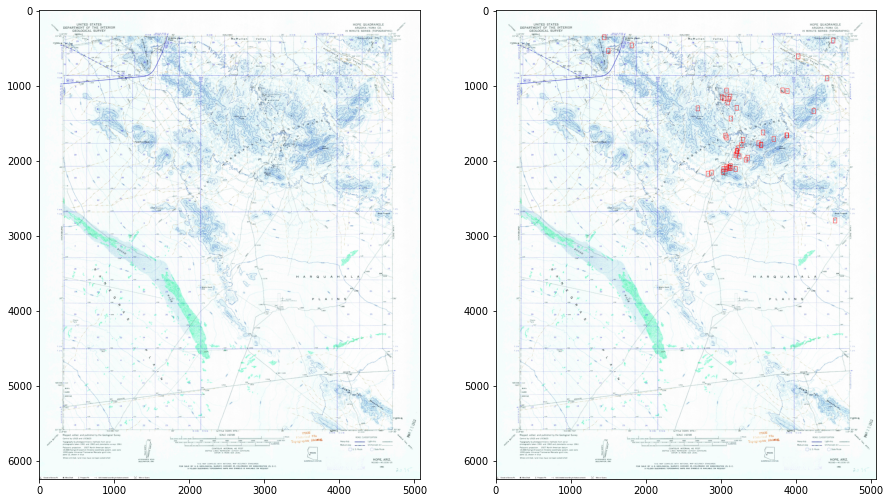

In [ ]:
#print(feature_filePath)

# Full Map Print
#annotations = generate_yolo_annotations(feature_img, legend_img.shape[0:2], 0)
#annotated_img = plot_bounding_box(base_img,annotations)

#fig, axs = plt.subplots(1, 2, figsize=(15, 15))
#axs[0].imshow(base_img)
#axs[1].imshow(annotated_img)
#plt.show()

training/AZ_Hope_314679_1961_62500_geo_mosaic_4_pt.tif


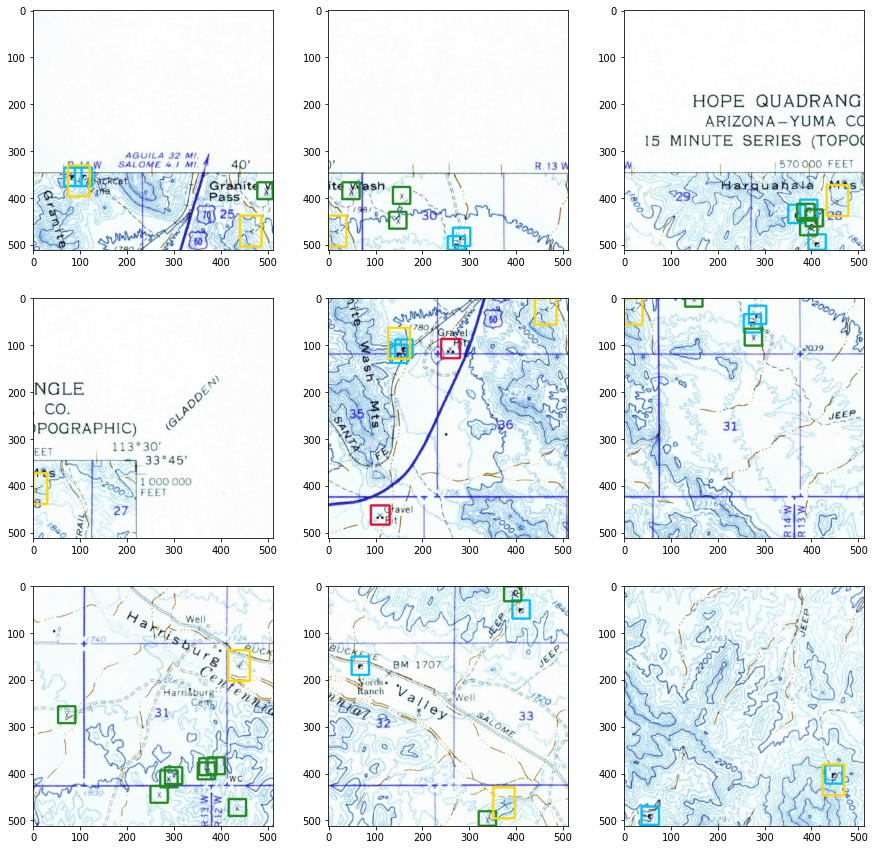

In [ ]:
#print(feature_filePath)

# Sample patches print
#fig, axs = plt.subplots(3, 3, figsize=(15, 15))
#fig_n = 0
#for row in range(0,feature_patchs.shape[0]):
#    if fig_n is 9:
#        break
#    for col in range(0,feature_patchs.shape[1]):
#        if fig_n is 9:
#            break
#        if np.argwhere(feature_patchs[row][col]).any():
#            patch_img = plot_bounding_box(base_patchs.squeeze()[row][col], map_patch_annotations[row][col])
#            axs[floor(fig_n/3)][fig_n%3].imshow(patch_img)
#            fig_n += 1
#plt.show()
#plt.close()

In [ ]:
#def find_bounding_box(base_img):
#    gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
#    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
#    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#    cnt = contours[0]
#    return cv2.boundingRect(cnt)

#x,y,w,h  = find_bounding_box(legend_img)
#bounded_legend = legend_img[y:y+h,x:x+w]

#Define the Model Architecture

## map_data.yaml

Needs to be updated for your dataset 
```
train: final_syn/images/train/ 
val:  final_syn/images/val/

# number of classes
nc: 49

# class names
names: ["bedding_overturned_pt.tif", "sample_locality_pt.tif", "paleomag_trans_pt.tif", "bedding_pt.tif", "1_pt.tif", "drumlin_pt.tif", "C14_pt.tif", "prospect_pit_pt.tif", "well_pt.tif", "IRSL_age_pt.tif", "monitoring_or_water__pt.tif", "fault_strike_dip_pt.tif", "coll_breccia_pipe_pt.tif", "geotechnical_boring_pt.tif", "vertical_foliation_pt.tif", "Saprolite_pt.tif", "C14_age_pt.tif", "dome_pt.tif", "Crystalline_rocks_pt.tif", "density_probe_pt.tif", "horizontal_bedding_pt.tif", "cross_bedding_igneou_pt.tif", "landslide_pt.tif", "erratic_block_pt.tif", "direction_of_ice_mov_pt.tif", "2_pt.tif", "field_exposure_pt.tif", "4_pt.tif", "teepee_butte_pt.tif", "5_pt.tif", "station_pt.tif", "Lower_Mesozoic_diaba_pt.tif", "bedding_vertical_pt.tif", "geotechnical_test_pi_pt.tif", "inclined_foliation_pt.tif", "paleomag_reversed_pt.tif", "Lower_Mesozoic_redbe_pt.tif", "landslide_from_winte_pt.tif", "channelling_igneous_pt.tif", "Paleozoic_sedimentar_pt.tif", "Jurassic_sedimentary_pt.tif", "3_pt.tif", "loc_strat_section_pt.tif", "bedding_inclined_pt.tif", "mine_shaft_pt.tif", "top_of_bed_pt.tif", "lineation_pt.tif", "bedding_graded_igneo_pt.tif", "cone_penetrometer_te_pt.tif"]
```

## hyp.scratch.yaml


```
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials


lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
```



## yolov5s.yaml
```
# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
```





In [ ]:
# yolo training call parameters
_img = 512
_cfg = 'yolov5s.yaml'
_hyp = 'hyp.scratch.yaml'
_batch = 32
_epochs = 100
_data = 'map_data.yaml'
_weights = 'yolov5s.pt'
_workers = 24
_name = 'map_pt_dect'

In [ ]:
!python train.py --img 512 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 16 --epochs 5 --data val_data.yaml --weights yolov5s.pt --workers 24 --name val_synth

In [ ]:
python train.py --img 512 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 16 --epochs 5 --data final_data.yaml --weights yolov5s.pt --workers 24 --name final_synth

In [ ]:
python3 detect.py --weights runs/train/final_synth/weights/best.pt --img 512 --conf 0.4 --source final_infer --save_txt --name final_anno

In [ ]:
python3 detect.py --weights runs/train/val_synth/weights/best.pt --img 512 --conf 0.4 --source val_infer --save_txt --name val_anno